In [1]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()
Pkg.status()

  Activating project at `c:\Users\MGAJ\OneDrive - Danmarks Tekniske Universitet\DTU\Physics-Informed-Regression`
┌ Warning: The project dependencies or compat requirements have changed since the manifest was last resolved.
│ It is recommended to `Pkg.resolve()` or consider `Pkg.update()` if necessary.
└ @ Pkg.API C:\Users\MGAJ\.julia\juliaup\julia-1.11.5+0.x64.w64.mingw32\share\julia\stdlib\v1.11\Pkg\src\API.jl:1206


Status `C:\Users\MGAJ\OneDrive - Danmarks Tekniske Universitet\DTU\Physics-Informed-Regression\Project.toml`
  [6e4b80f9] BenchmarkTools v1.6.0
  [479239e8] Catalyst v15.0.8
  [a93c6f00] DataFrames v1.7.0
  [0c46a032] DifferentialEquations v7.16.1
  [5b8099bc] DomainSets v0.7.15
  [a98d9a8b] Interpolations v0.16.1
  [b964fa9f] LaTeXStrings v1.4.0
  [23fbe1c1] Latexify v0.16.8
  [23992714] MAT v0.10.7
⌃ [94925ecb] MethodOfLines v0.11.8
⌅ [961ee093] ModelingToolkit v9.80.2
  [1dea7af3] OrdinaryDiffEq v6.98.0
  [b39d95ae] PhysicsInformedRegression v1.0.1 `https://github.com/MarcusGalea/PhysicsInformedRegression.jl.git#PDE_handling`
  [91a5bcdd] Plots v1.40.13
  [08abe8d2] PrettyTables v2.4.0
Info Packages marked with ⌃ and ⌅ have new versions available. Those with ⌃ may be upgradable, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated`
Warning The project dependencies or compat requirements have changed since the manifest was las

In [2]:
using ModelingToolkit, MethodOfLines, OrdinaryDiffEq, DomainSets
using PhysicsInformedRegression,MAT,Plots, Interpolations

# Loading Data

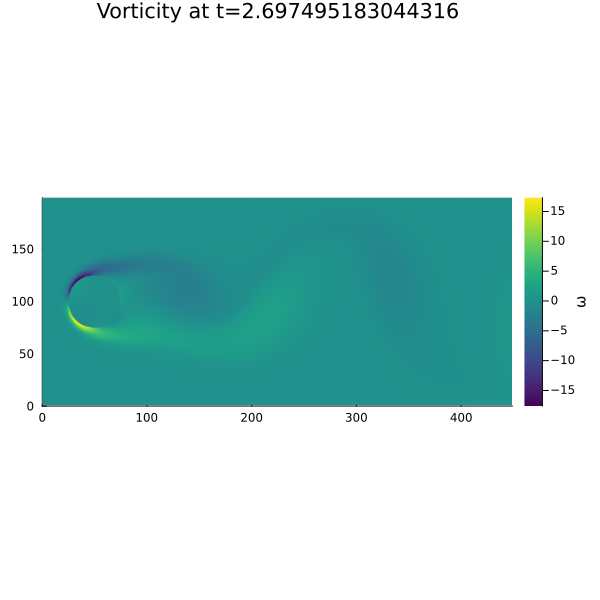

In [3]:

#### Real data

data = matread("../data/CYLINDER_ALL.mat") #load the data from the .mat file ( not uploaded to GitHub. Folder must be created manually)


#reshape the data (reordered for some reason)
nx = Int(data["ny"]) #number of points in the x direction (449)
ny = Int(data["nx"]) #number of points in the y direction (199)
N = 151 #number of time steps

# Parameters
Lx = 8.96
Ly = 3.96
ST = 0.173 #Strouhal number at Re = 100
T = 1/ST  #period of the vortex shedding
dt = T / (N - 1) #time step size



ω_data = reshape(data["VORTALL"], ny, nx, N)
u_data = reshape(data["UALL"], ny, nx, N)
v_data = reshape(data["VALL"], ny, nx, N)

#reorder indices to match symbolic model
ω_data = permutedims(ω_data, (2, 1, 3)) #from (y,x,t) to (x,y,t)
u_data = permutedims(u_data, (2, 1, 3)) #from (y,x,t) to (x,y,t)
v_data = permutedims(v_data, (2, 1, 3)) #from (y,x,t) to (x,y,t)


#show the data at a specific time step
n = 70
heatmap(ω_data[:,:,n]', aspect_ratio = 1, title = "Vorticity at t=$(n*dt)", colorbar_title = "ω", c=:viridis, xlim = (0, nx), ylim = (0, ny), size = (600, 600))

# Symbolic Model

In [25]:
@parameters ν_inv
@independent_variables t x y
@variables ω(..) u(..) v(..)

# Domain
x_dom = Interval(0.0, Lx)
y_dom = Interval(0.0, Ly)
t_dom = Interval(0.0, T)
domains = [x ∈ x_dom, y ∈ y_dom, t ∈ t_dom]

# Differential operators
Dt = Differential(t)
Dx = Differential(x)
Dy = Differential(y)
Dxx = Differential(x)^2
Dyy = Differential(y)^2



ivs = [x,y,t]
dvs = [ω(x,y,t), u(x,y,t), v(x,y,t)]

# Vorticity equation (2D Navier-Stokes)
eq = Dt(ω(x,y,t)) + u(x,y,t) * Dx(ω(x,y,t)) + v(x,y,t) * Dy(ω(x,y,t)) ~ ν_inv * (Dxx(ω(x,y,t)) + Dyy(ω(x,y,t)))

bcs = [
    ω(0, y, t) ~ ω_data[1,:,:], # left boundary condition
    ω(Lx, y, t) ~ ω_data[end,:,:], # right boundary condition
    ω(x, 0, t) ~ ω_data[:,1,:], # bottom boundary condition
    ω(x, Ly, t) ~ ω_data[:,end,:], # top boundary condition
    u(0, y, t) ~ u_data[1,:,:], # left boundary condition for u
    u(Lx, y, t) ~ u_data[end,:,:], # right boundary condition for u
    v(x, 0, t) ~ v_data[:,1,:], # bottom boundary condition for v
    v(x, Ly, t) ~ v_data[:,end,:] # top boundary condition for v
]
@named pdesys = PDESystem(eq, bcs, domains, ivs, dvs, [ν_inv])

PDESystem
Equations: Equation[Differential(t)(ω(x, y, t)) + Differential(y)(ω(x, y, t))*v(x, y, t) + u(x, y, t)*Differential(x)(ω(x, y, t)) ~ (Differential(x)(Differential(x)(ω(x, y, t))) + Differential(y)(Differential(y)(ω(x, y, t))))*ν_inv]
Boundary Conditions: Equation[ω(0, y, t) ~ [-9.37978e-15 -8.81369e-15 … -9.41491e-15 -9.30876e-15; -9.30657e-15 -8.89068e-15 … -9.56562e-15 -9.35889e-15; … ; -2.80132e-15 -1.07471e-15 … -8.8313e-16 -8.27603e-16; -2.50876e-15 -9.2954e-16 … -7.37336e-16 -5.60111e-16], ω(8.96, y, t) ~ [7.16467e-6 4.54665e-5 … 2.10211e-7 9.5546e-7; 8.40519e-6 5.35305e-5 … 2.46567e-7 1.11606e-6; … ; -0.0305893 -0.0299358 … -0.0819676 -0.0475584; -0.0438674 -0.0412466 … -0.096491 -0.0618917], ω(x, 0, t) ~ [-9.37978e-15 -8.81369e-15 … -9.41491e-15 -9.30876e-15; -9.39541e-15 -9.00114e-15 … -9.57838e-15 -9.51016e-15; … ; 8.52219e-6 5.41583e-5 … 2.37792e-7 1.1262e-6; 7.16467e-6 4.54665e-5 … 2.10211e-7 9.5546e-7], ω(x, 3.96, t) ~ [-2.50876e-15 -9.2954e-16 … -7.37336e-16 -5.6

In [24]:
ω_data[end, :, :]

199×151 Matrix{Float64}:
  7.16467e-6   4.54665e-5    0.000295948  …   2.10211e-7    9.5546e-7
  8.40519e-6   5.35305e-5    0.000349397      2.46567e-7    1.11606e-6
  9.87634e-6   6.31079e-5    0.000412742      2.89436e-7    1.30564e-6
  1.16121e-5   7.44396e-5    0.000487645      3.39581e-7    1.52801e-6
  1.36545e-5   8.77841e-5    0.000575607      3.98312e-7    1.78863e-6
  1.60521e-5   0.000103482   0.000678913  …   4.66738e-7    2.09297e-6
  1.88602e-5   0.000121869   0.000799457      5.46617e-7    2.44823e-6
  2.2141e-5    0.000143378   0.000940104      6.39363e-7    2.86135e-6
  2.59655e-5   0.000168436   0.00110317       7.47278e-7    3.34161e-6
  3.0412e-5    0.000197584   0.00129217       8.72143e-7    3.8977e-6
  ⋮                                       ⋱                 ⋮
  0.0661146    0.0653849     0.0482752    …   0.0114017     0.046623
  0.0534427    0.0514275     0.0342776        0.000523834   0.0353636
  0.0400508    0.0372527     0.0206989       -0.0114677     0.0230

# mapping symbolic model to data

In [5]:
##### Physics-informed regression
dx = Lx / (nx - 1)
dy = Ly / (ny - 1)
datainfo = Dict(
            t => 0:dt:T, #LinRange(0, T, N), #
            x => 0:dx:Lx, #LinRange(0, Lx, W), #
            y => 0:dy:Ly, #LinRange(0, Lx, H), #
            ω(x,y,t) => ω_data,
            u(x,y,t) => u_data,
            v(x,y,t) => v_data,
) #map symbolic variables to data

Dict{Num, AbstractArray{Float64}} with 6 entries:
  u(x, y, t) => [1.01243 1.01186 … 1.01862 1.019; 1.01394 1.01323 … 1.02001 1.0…
  t          => 0.0:0.03853564547206166:5.780346820809249
  ω(x, y, t) => [-9.37978e-15 -9.30657e-15 … -2.80132e-15 -2.50876e-15; -9.3954…
  v(x, y, t) => [-0.11537 -0.116503 … 0.108284 0.107065; -0.11591 -0.117236 … 0…
  y          => 0.0:0.02:3.96
  x          => 0.0:0.02:8.96

# Sampling and spatial / temporal derivatives

In [6]:
using Random
Ns = 1000

Random.seed!(3) #for reproducibility
# #size of v_data is (nx, ny, N)
x_samples,y_samples,t_samples = rand(100:150, Ns), rand(50:149, Ns), collect(1:N) #sample time steps (1 to N)
samples = vcat([CartesianIndex.(x_samples,y_samples, t*ones(Int, Ns)) for t in t_samples]...)

151000-element Vector{CartesianIndex{3}}:
 CartesianIndex(117, 70, 1)
 CartesianIndex(148, 62, 1)
 CartesianIndex(150, 93, 1)
 CartesianIndex(104, 124, 1)
 CartesianIndex(135, 148, 1)
 CartesianIndex(125, 121, 1)
 CartesianIndex(148, 85, 1)
 CartesianIndex(140, 87, 1)
 CartesianIndex(140, 72, 1)
 CartesianIndex(125, 133, 1)
 ⋮
 CartesianIndex(121, 70, 151)
 CartesianIndex(121, 103, 151)
 CartesianIndex(146, 84, 151)
 CartesianIndex(142, 114, 151)
 CartesianIndex(110, 104, 151)
 CartesianIndex(116, 90, 151)
 CartesianIndex(131, 111, 151)
 CartesianIndex(125, 138, 151)
 CartesianIndex(137, 141, 151)

In [7]:
#
observations = PhysicsInformedRegression.Observations(samples, 
                            [x,y,t], 
                            [ω(x,y,t), u(x,y,t), v(x,y,t)],
                            datainfo;
                            data_structure = Dict{CartesianIndex, Observation}()) #Finite difference data structure

Dict{CartesianIndex, Observation} with 136655 entries:
  CartesianIndex(135, 97, 63)   => ω(2.7, 1.9, 2.4) = -0.26…
  CartesianIndex(107, 101, 15)  => ω(2.1, 2.0, 0.54) = 0.57…
  CartesianIndex(132, 137, 29)  => ω(2.6, 2.7, 1.1) = -1.5…
  CartesianIndex(117, 95, 45)   => ω(2.3, 1.9, 1.7) = 1.1…
  CartesianIndex(100, 53, 31)   => ω(2.0, 1.0, 1.2) = 1.3…
  CartesianIndex(143, 87, 131)  => ω(2.8, 1.7, 5.0) = -1.3…
  CartesianIndex(139, 112, 87)  => ω(2.8, 2.2, 3.3) = 1.1…
  CartesianIndex(105, 64, 145)  => ω(2.1, 1.3, 5.5) = 2.9…
  CartesianIndex(132, 108, 10)  => ω(2.6, 2.1, 0.35) = -2.5…
  CartesianIndex(103, 121, 98)  => ω(2.0, 2.4, 3.7) = -1.7…
  CartesianIndex(147, 69, 125)  => ω(2.9, 1.4, 4.8) = 1.8…
  CartesianIndex(144, 100, 17)  => ω(2.9, 2.0, 0.62) = -0.56…
  CartesianIndex(107, 94, 128)  => ω(2.1, 1.9, 4.9) = -0.51…
  CartesianIndex(125, 69, 39)   => ω(2.5, 1.4, 1.5) = 1.9…
  CartesianIndex(110, 78, 37)   => ω(2.2, 1.5, 1.4) = 1.1…
  CartesianIndex(113, 104, 33)  => ω(2.2, 2.1,

In [8]:
#Sanity check
observation = observations[samples[1]]
println("Observation $observation")

println("Observation jacobian: $(observation.jacobian)") # 3 by 3 matrix for 3 variables (ω, u, v) with respect to 3 independent variables (x, y, t)
println("Observation hessian: $(observation.hessian)") # 3 by 3 matrix for 3 variables (ω, u, v) with respect to 3 independent variables (x, y, t)

Observation ω(2.3, 1.4, 0.0) = 1.6
u(2.3, 1.4, 0.0) = 0.43
v(2.3, 1.4, 0.0) = -0.14

Observation jacobian: [0.07300000000000077 -5.415250000000024 -1.423876499999999; 0.48262499999999997 -1.7549500000000091 -1.4277949499999996; -0.17455000000000023 -0.4826250000000027 0.31659000000000037]
Observation hessian: [5.231250000000122 13.918750000000058 -7.655250000000013; 0.7143750000000358 0.727500000000001 -1.9008375000000266; 0.8006250000000014 -0.7156249999999897 -2.3569087499999872;;; 13.918750000000056 37.45000000000111 -1.4012999999999607; 0.7275000000000025 4.663750000000288 -0.9296587499999825; -0.71562499999999 -0.7274999999999372 1.9001887500000196;;; -7.655250000000012 -1.4012999999999673 11.43100743749997; -1.9008375000000282 -0.9296587499999774 0.9707097037500109; -2.3569087499999855 1.9001887500000194 3.8757680887499877]


### PIR

In [9]:
# Parameter estimation
paramsest = PhysicsInformedRegression.physics_informed_regression(pdesys, datainfo; samples = samples)

Dict{Num, Float64} with 1 entry:
  ν_inv => 0.00158601

In [10]:
println("Estimated Reynolds number $(1/paramsest[ν_inv])") #inverse of the estimated ν_inv

Estimated Reynolds number 630.5142067071167


## PIR with symbolic discretization


In [31]:
using MethodOfLines
#create discretization
approx_order = 2
discretization = MethodOfLines.MOLFiniteDifference([x=>dx, y=>dy], t, approx_order = approx_order; advection_scheme = UpwindScheme())
discretized_sys = discretize(pdesys, discretization)

AssertionError: AssertionError: There must be the same number of equations and unknowns, got 1 equations and 3 unknowns